# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

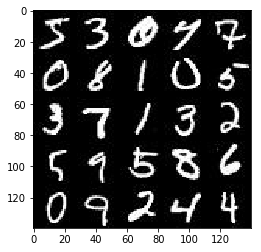

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

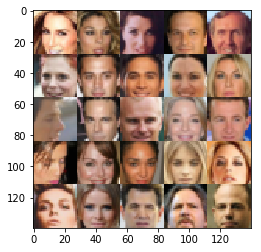

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, shape=(None, z_dim), name='nputs_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        x4 = tf.layers.conv2d(relu3, 512, 5, strides=1, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        
        flat = tf.reshape(relu4, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=False if is_train==True else True):
        alpha = 0.2
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.maximum(alpha * x1, x1)

        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=1, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)

        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
   
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    
    d_loss_fake = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
        
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
   
    n_samples, width, height, channels = data_shape
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                # TODO: Train Model
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % 100 == 0:
                    n_images = 25
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)

                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{} Step {}...".format(epoch_i+1, epoch_count, steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 Step 10... Discriminator Loss: 1.8523... Generator Loss: 0.3692
Epoch 1/2 Step 20... Discriminator Loss: 1.0581... Generator Loss: 0.8882
Epoch 1/2 Step 30... Discriminator Loss: 1.3543... Generator Loss: 0.9275
Epoch 1/2 Step 40... Discriminator Loss: 0.7164... Generator Loss: 1.0928
Epoch 1/2 Step 50... Discriminator Loss: 0.4998... Generator Loss: 1.3351
Epoch 1/2 Step 60... Discriminator Loss: 0.2897... Generator Loss: 2.0648
Epoch 1/2 Step 70... Discriminator Loss: 0.4480... Generator Loss: 2.2984
Epoch 1/2 Step 80... Discriminator Loss: 0.1924... Generator Loss: 2.2709
Epoch 1/2 Step 90... Discriminator Loss: 0.2833... Generator Loss: 1.7856


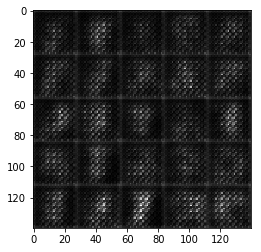

Epoch 1/2 Step 100... Discriminator Loss: 1.2739... Generator Loss: 0.7480
Epoch 1/2 Step 110... Discriminator Loss: 1.1152... Generator Loss: 1.2200
Epoch 1/2 Step 120... Discriminator Loss: 1.2370... Generator Loss: 0.7171
Epoch 1/2 Step 130... Discriminator Loss: 0.8186... Generator Loss: 1.1642
Epoch 1/2 Step 140... Discriminator Loss: 0.7221... Generator Loss: 1.3200
Epoch 1/2 Step 150... Discriminator Loss: 0.6180... Generator Loss: 1.6364
Epoch 1/2 Step 160... Discriminator Loss: 0.8990... Generator Loss: 1.0010
Epoch 1/2 Step 170... Discriminator Loss: 0.9011... Generator Loss: 0.9916
Epoch 1/2 Step 180... Discriminator Loss: 1.0462... Generator Loss: 0.8401
Epoch 1/2 Step 190... Discriminator Loss: 0.9074... Generator Loss: 1.1772


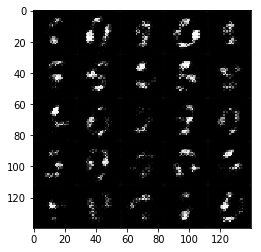

Epoch 1/2 Step 200... Discriminator Loss: 1.2477... Generator Loss: 1.0348
Epoch 1/2 Step 210... Discriminator Loss: 1.2437... Generator Loss: 1.2095
Epoch 1/2 Step 220... Discriminator Loss: 0.9684... Generator Loss: 0.9681
Epoch 1/2 Step 230... Discriminator Loss: 1.2299... Generator Loss: 0.5276
Epoch 1/2 Step 240... Discriminator Loss: 0.7161... Generator Loss: 1.2056
Epoch 1/2 Step 250... Discriminator Loss: 0.9774... Generator Loss: 1.0114
Epoch 1/2 Step 260... Discriminator Loss: 1.3979... Generator Loss: 0.6478
Epoch 1/2 Step 270... Discriminator Loss: 1.2182... Generator Loss: 0.8852
Epoch 1/2 Step 280... Discriminator Loss: 1.2581... Generator Loss: 2.1066
Epoch 1/2 Step 290... Discriminator Loss: 0.7458... Generator Loss: 1.9676


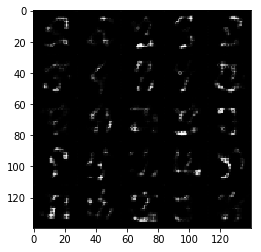

Epoch 1/2 Step 300... Discriminator Loss: 1.5717... Generator Loss: 0.3628
Epoch 1/2 Step 310... Discriminator Loss: 1.6338... Generator Loss: 0.6006
Epoch 1/2 Step 320... Discriminator Loss: 1.4179... Generator Loss: 0.7481
Epoch 1/2 Step 330... Discriminator Loss: 1.2729... Generator Loss: 0.8184
Epoch 1/2 Step 340... Discriminator Loss: 1.2719... Generator Loss: 0.6792
Epoch 1/2 Step 350... Discriminator Loss: 1.1594... Generator Loss: 0.8074
Epoch 1/2 Step 360... Discriminator Loss: 1.0602... Generator Loss: 0.9306
Epoch 1/2 Step 370... Discriminator Loss: 1.2289... Generator Loss: 0.8396
Epoch 1/2 Step 380... Discriminator Loss: 1.0886... Generator Loss: 0.9112
Epoch 1/2 Step 390... Discriminator Loss: 1.5311... Generator Loss: 0.5737


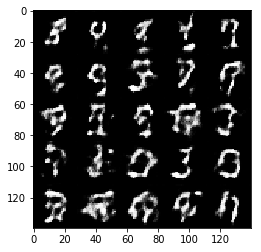

Epoch 1/2 Step 400... Discriminator Loss: 1.3119... Generator Loss: 0.5185
Epoch 1/2 Step 410... Discriminator Loss: 1.0881... Generator Loss: 1.0738
Epoch 1/2 Step 420... Discriminator Loss: 1.0788... Generator Loss: 1.0082
Epoch 1/2 Step 430... Discriminator Loss: 1.0799... Generator Loss: 1.0454
Epoch 1/2 Step 440... Discriminator Loss: 1.1464... Generator Loss: 0.7041
Epoch 1/2 Step 450... Discriminator Loss: 0.8368... Generator Loss: 1.0351
Epoch 1/2 Step 460... Discriminator Loss: 1.1617... Generator Loss: 1.1781
Epoch 1/2 Step 470... Discriminator Loss: 1.2700... Generator Loss: 0.9653
Epoch 1/2 Step 480... Discriminator Loss: 1.3239... Generator Loss: 1.0630
Epoch 1/2 Step 490... Discriminator Loss: 1.2948... Generator Loss: 0.5209


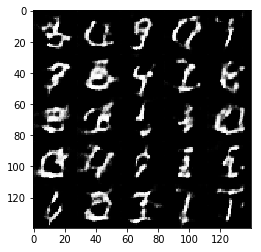

Epoch 1/2 Step 500... Discriminator Loss: 1.2973... Generator Loss: 0.5678
Epoch 1/2 Step 510... Discriminator Loss: 1.2415... Generator Loss: 0.6265
Epoch 1/2 Step 520... Discriminator Loss: 1.0115... Generator Loss: 0.8833
Epoch 1/2 Step 530... Discriminator Loss: 1.2404... Generator Loss: 1.0453
Epoch 1/2 Step 540... Discriminator Loss: 1.1464... Generator Loss: 0.5696
Epoch 1/2 Step 550... Discriminator Loss: 1.0864... Generator Loss: 1.1596
Epoch 1/2 Step 560... Discriminator Loss: 1.1110... Generator Loss: 0.9029
Epoch 1/2 Step 570... Discriminator Loss: 1.2215... Generator Loss: 0.6803
Epoch 1/2 Step 580... Discriminator Loss: 1.1940... Generator Loss: 0.7404
Epoch 1/2 Step 590... Discriminator Loss: 1.1799... Generator Loss: 0.7753


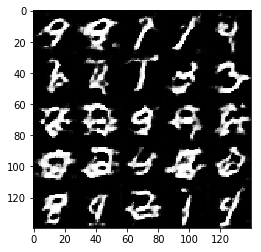

Epoch 1/2 Step 600... Discriminator Loss: 1.0696... Generator Loss: 1.0035
Epoch 1/2 Step 610... Discriminator Loss: 1.0488... Generator Loss: 0.7392
Epoch 1/2 Step 620... Discriminator Loss: 1.2367... Generator Loss: 0.9188
Epoch 1/2 Step 630... Discriminator Loss: 1.1321... Generator Loss: 0.5537
Epoch 1/2 Step 640... Discriminator Loss: 1.1303... Generator Loss: 0.6424
Epoch 1/2 Step 650... Discriminator Loss: 1.2806... Generator Loss: 0.6614
Epoch 1/2 Step 660... Discriminator Loss: 1.1352... Generator Loss: 1.4040
Epoch 1/2 Step 670... Discriminator Loss: 0.9514... Generator Loss: 1.2649
Epoch 1/2 Step 680... Discriminator Loss: 1.4965... Generator Loss: 0.3837
Epoch 1/2 Step 690... Discriminator Loss: 1.0011... Generator Loss: 0.8337


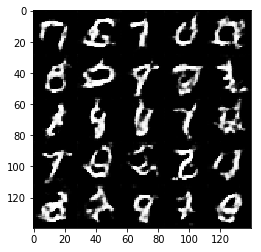

Epoch 1/2 Step 700... Discriminator Loss: 1.1982... Generator Loss: 0.7567
Epoch 1/2 Step 710... Discriminator Loss: 1.1362... Generator Loss: 0.7741
Epoch 1/2 Step 720... Discriminator Loss: 1.3311... Generator Loss: 0.4346
Epoch 1/2 Step 730... Discriminator Loss: 1.0631... Generator Loss: 0.9698
Epoch 1/2 Step 740... Discriminator Loss: 2.0004... Generator Loss: 0.3647
Epoch 1/2 Step 750... Discriminator Loss: 1.2478... Generator Loss: 0.6095
Epoch 1/2 Step 760... Discriminator Loss: 1.0306... Generator Loss: 0.6020
Epoch 1/2 Step 770... Discriminator Loss: 1.0469... Generator Loss: 0.7018
Epoch 1/2 Step 780... Discriminator Loss: 1.4894... Generator Loss: 0.4062
Epoch 1/2 Step 790... Discriminator Loss: 1.2632... Generator Loss: 0.5103


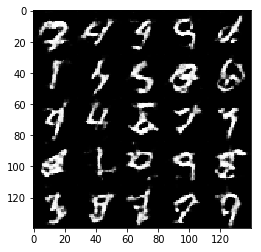

Epoch 1/2 Step 800... Discriminator Loss: 0.8659... Generator Loss: 0.8469
Epoch 1/2 Step 810... Discriminator Loss: 0.9946... Generator Loss: 0.6923
Epoch 1/2 Step 820... Discriminator Loss: 0.8747... Generator Loss: 1.4705
Epoch 1/2 Step 830... Discriminator Loss: 1.0900... Generator Loss: 0.5149
Epoch 1/2 Step 840... Discriminator Loss: 0.7463... Generator Loss: 1.1641
Epoch 1/2 Step 850... Discriminator Loss: 0.9782... Generator Loss: 0.9634
Epoch 1/2 Step 860... Discriminator Loss: 1.8121... Generator Loss: 0.8844
Epoch 1/2 Step 870... Discriminator Loss: 1.1821... Generator Loss: 0.9681
Epoch 1/2 Step 880... Discriminator Loss: 0.9287... Generator Loss: 0.8215
Epoch 1/2 Step 890... Discriminator Loss: 0.8505... Generator Loss: 1.3101


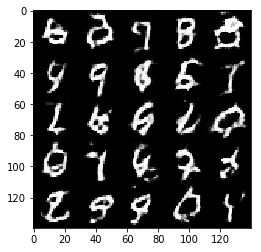

Epoch 1/2 Step 900... Discriminator Loss: 0.7812... Generator Loss: 1.7514
Epoch 1/2 Step 910... Discriminator Loss: 0.9997... Generator Loss: 0.7962
Epoch 1/2 Step 920... Discriminator Loss: 0.9379... Generator Loss: 1.0122
Epoch 1/2 Step 930... Discriminator Loss: 1.0447... Generator Loss: 0.6227
Epoch 2/2 Step 940... Discriminator Loss: 1.2146... Generator Loss: 0.8493
Epoch 2/2 Step 950... Discriminator Loss: 0.8700... Generator Loss: 1.5357
Epoch 2/2 Step 960... Discriminator Loss: 1.4143... Generator Loss: 0.3407
Epoch 2/2 Step 970... Discriminator Loss: 1.3946... Generator Loss: 0.4965
Epoch 2/2 Step 980... Discriminator Loss: 1.0882... Generator Loss: 0.6235
Epoch 2/2 Step 990... Discriminator Loss: 1.2289... Generator Loss: 0.7122


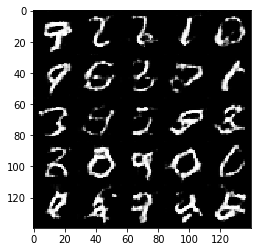

Epoch 2/2 Step 1000... Discriminator Loss: 0.8821... Generator Loss: 1.2182
Epoch 2/2 Step 1010... Discriminator Loss: 1.2453... Generator Loss: 0.5158
Epoch 2/2 Step 1020... Discriminator Loss: 1.2839... Generator Loss: 0.4237
Epoch 2/2 Step 1030... Discriminator Loss: 0.8072... Generator Loss: 1.0014
Epoch 2/2 Step 1040... Discriminator Loss: 0.9848... Generator Loss: 0.8589
Epoch 2/2 Step 1050... Discriminator Loss: 0.8204... Generator Loss: 0.9286
Epoch 2/2 Step 1060... Discriminator Loss: 1.1341... Generator Loss: 0.7867
Epoch 2/2 Step 1070... Discriminator Loss: 0.7284... Generator Loss: 1.5245
Epoch 2/2 Step 1080... Discriminator Loss: 0.9474... Generator Loss: 0.7429
Epoch 2/2 Step 1090... Discriminator Loss: 0.9583... Generator Loss: 1.4291


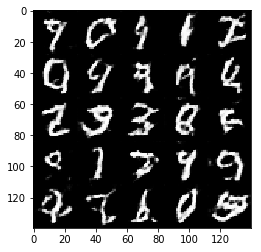

Epoch 2/2 Step 1100... Discriminator Loss: 0.8469... Generator Loss: 1.0692
Epoch 2/2 Step 1110... Discriminator Loss: 0.8862... Generator Loss: 1.4901
Epoch 2/2 Step 1120... Discriminator Loss: 0.7538... Generator Loss: 1.2828
Epoch 2/2 Step 1130... Discriminator Loss: 0.6292... Generator Loss: 1.3813
Epoch 2/2 Step 1140... Discriminator Loss: 0.9265... Generator Loss: 0.9865
Epoch 2/2 Step 1150... Discriminator Loss: 1.3575... Generator Loss: 0.3743
Epoch 2/2 Step 1160... Discriminator Loss: 1.1450... Generator Loss: 1.3507
Epoch 2/2 Step 1170... Discriminator Loss: 1.3122... Generator Loss: 0.8968
Epoch 2/2 Step 1180... Discriminator Loss: 0.9249... Generator Loss: 0.7459
Epoch 2/2 Step 1190... Discriminator Loss: 0.8920... Generator Loss: 0.9381


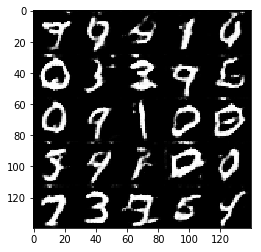

Epoch 2/2 Step 1200... Discriminator Loss: 0.9072... Generator Loss: 2.1455
Epoch 2/2 Step 1210... Discriminator Loss: 0.9251... Generator Loss: 0.7476
Epoch 2/2 Step 1220... Discriminator Loss: 0.6683... Generator Loss: 1.7737
Epoch 2/2 Step 1230... Discriminator Loss: 0.8226... Generator Loss: 1.2534
Epoch 2/2 Step 1240... Discriminator Loss: 1.0766... Generator Loss: 0.6531
Epoch 2/2 Step 1250... Discriminator Loss: 1.8322... Generator Loss: 2.5002
Epoch 2/2 Step 1260... Discriminator Loss: 0.9284... Generator Loss: 0.9510
Epoch 2/2 Step 1270... Discriminator Loss: 1.1045... Generator Loss: 0.5358
Epoch 2/2 Step 1280... Discriminator Loss: 1.1695... Generator Loss: 0.8023
Epoch 2/2 Step 1290... Discriminator Loss: 1.5247... Generator Loss: 0.3628


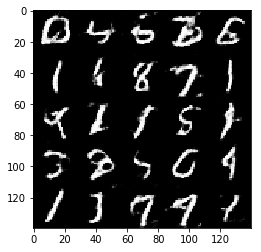

Epoch 2/2 Step 1300... Discriminator Loss: 0.6021... Generator Loss: 1.4120
Epoch 2/2 Step 1310... Discriminator Loss: 0.5463... Generator Loss: 1.3091
Epoch 2/2 Step 1320... Discriminator Loss: 1.3316... Generator Loss: 0.7782
Epoch 2/2 Step 1330... Discriminator Loss: 1.2688... Generator Loss: 0.9239
Epoch 2/2 Step 1340... Discriminator Loss: 0.6643... Generator Loss: 1.6213
Epoch 2/2 Step 1350... Discriminator Loss: 1.4478... Generator Loss: 1.1760
Epoch 2/2 Step 1360... Discriminator Loss: 0.7261... Generator Loss: 1.7210
Epoch 2/2 Step 1370... Discriminator Loss: 1.0038... Generator Loss: 0.5995
Epoch 2/2 Step 1380... Discriminator Loss: 0.6862... Generator Loss: 1.0487
Epoch 2/2 Step 1390... Discriminator Loss: 0.6043... Generator Loss: 1.3204


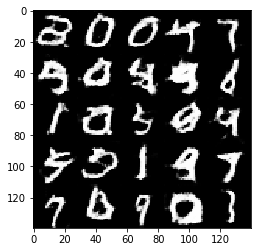

Epoch 2/2 Step 1400... Discriminator Loss: 1.6217... Generator Loss: 2.6716
Epoch 2/2 Step 1410... Discriminator Loss: 1.6160... Generator Loss: 0.9983
Epoch 2/2 Step 1420... Discriminator Loss: 1.1267... Generator Loss: 1.9386
Epoch 2/2 Step 1430... Discriminator Loss: 1.2514... Generator Loss: 0.4488
Epoch 2/2 Step 1440... Discriminator Loss: 1.0103... Generator Loss: 0.5928
Epoch 2/2 Step 1450... Discriminator Loss: 1.0890... Generator Loss: 0.7368
Epoch 2/2 Step 1460... Discriminator Loss: 0.9007... Generator Loss: 0.7323
Epoch 2/2 Step 1470... Discriminator Loss: 0.8832... Generator Loss: 0.8358
Epoch 2/2 Step 1480... Discriminator Loss: 1.0369... Generator Loss: 0.5476
Epoch 2/2 Step 1490... Discriminator Loss: 0.7452... Generator Loss: 1.1164


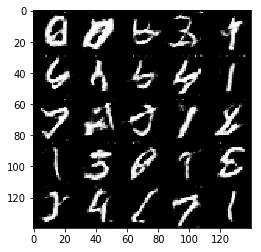

Epoch 2/2 Step 1500... Discriminator Loss: 1.0202... Generator Loss: 1.1079
Epoch 2/2 Step 1510... Discriminator Loss: 1.0194... Generator Loss: 0.6637
Epoch 2/2 Step 1520... Discriminator Loss: 0.6893... Generator Loss: 1.1643
Epoch 2/2 Step 1530... Discriminator Loss: 0.7351... Generator Loss: 0.8936
Epoch 2/2 Step 1540... Discriminator Loss: 0.5378... Generator Loss: 1.5681
Epoch 2/2 Step 1550... Discriminator Loss: 0.5725... Generator Loss: 1.0526
Epoch 2/2 Step 1560... Discriminator Loss: 0.9013... Generator Loss: 0.9046
Epoch 2/2 Step 1570... Discriminator Loss: 0.6371... Generator Loss: 1.9073
Epoch 2/2 Step 1580... Discriminator Loss: 0.6677... Generator Loss: 1.0164
Epoch 2/2 Step 1590... Discriminator Loss: 1.3951... Generator Loss: 1.2534


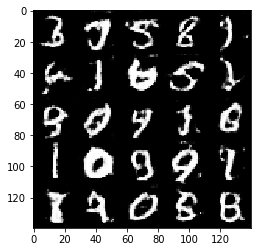

Epoch 2/2 Step 1600... Discriminator Loss: 0.9797... Generator Loss: 2.2086
Epoch 2/2 Step 1610... Discriminator Loss: 1.1157... Generator Loss: 1.0498
Epoch 2/2 Step 1620... Discriminator Loss: 1.0020... Generator Loss: 0.6947
Epoch 2/2 Step 1630... Discriminator Loss: 1.3552... Generator Loss: 0.3880
Epoch 2/2 Step 1640... Discriminator Loss: 1.1995... Generator Loss: 0.6370
Epoch 2/2 Step 1650... Discriminator Loss: 0.8274... Generator Loss: 0.9228
Epoch 2/2 Step 1660... Discriminator Loss: 1.1751... Generator Loss: 0.5304
Epoch 2/2 Step 1670... Discriminator Loss: 0.5929... Generator Loss: 1.1640
Epoch 2/2 Step 1680... Discriminator Loss: 0.4819... Generator Loss: 1.2551
Epoch 2/2 Step 1690... Discriminator Loss: 0.5583... Generator Loss: 1.1206


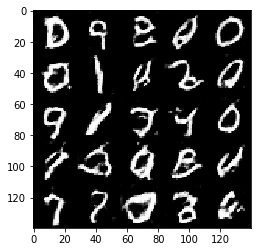

Epoch 2/2 Step 1700... Discriminator Loss: 1.5598... Generator Loss: 0.3726
Epoch 2/2 Step 1710... Discriminator Loss: 0.8186... Generator Loss: 0.8373
Epoch 2/2 Step 1720... Discriminator Loss: 1.8405... Generator Loss: 0.2846
Epoch 2/2 Step 1730... Discriminator Loss: 1.2176... Generator Loss: 0.4870
Epoch 2/2 Step 1740... Discriminator Loss: 0.6055... Generator Loss: 1.3264
Epoch 2/2 Step 1750... Discriminator Loss: 0.7992... Generator Loss: 0.7721
Epoch 2/2 Step 1760... Discriminator Loss: 0.6873... Generator Loss: 1.1233
Epoch 2/2 Step 1770... Discriminator Loss: 0.8481... Generator Loss: 0.7894
Epoch 2/2 Step 1780... Discriminator Loss: 1.2997... Generator Loss: 0.5562
Epoch 2/2 Step 1790... Discriminator Loss: 1.1043... Generator Loss: 0.9331


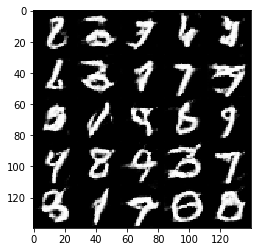

Epoch 2/2 Step 1800... Discriminator Loss: 1.4580... Generator Loss: 0.9443
Epoch 2/2 Step 1810... Discriminator Loss: 0.9234... Generator Loss: 0.8383
Epoch 2/2 Step 1820... Discriminator Loss: 1.5761... Generator Loss: 0.3721
Epoch 2/2 Step 1830... Discriminator Loss: 1.1689... Generator Loss: 0.4735
Epoch 2/2 Step 1840... Discriminator Loss: 1.2284... Generator Loss: 0.4843
Epoch 2/2 Step 1850... Discriminator Loss: 1.0619... Generator Loss: 2.0125
Epoch 2/2 Step 1860... Discriminator Loss: 0.8488... Generator Loss: 0.8226
Epoch 2/2 Step 1870... Discriminator Loss: 0.8107... Generator Loss: 1.2299


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 Step 10... Discriminator Loss: 1.3982... Generator Loss: 1.4190
Epoch 1/1 Step 20... Discriminator Loss: 0.6468... Generator Loss: 1.3905
Epoch 1/1 Step 30... Discriminator Loss: 0.6790... Generator Loss: 1.5116
Epoch 1/1 Step 40... Discriminator Loss: 0.1252... Generator Loss: 2.7936
Epoch 1/1 Step 50... Discriminator Loss: 1.7030... Generator Loss: 1.7746
Epoch 1/1 Step 60... Discriminator Loss: 0.1742... Generator Loss: 2.5064
Epoch 1/1 Step 70... Discriminator Loss: 0.1232... Generator Loss: 2.8559
Epoch 1/1 Step 80... Discriminator Loss: 0.0715... Generator Loss: 3.4613
Epoch 1/1 Step 90... Discriminator Loss: 0.2814... Generator Loss: 1.6549


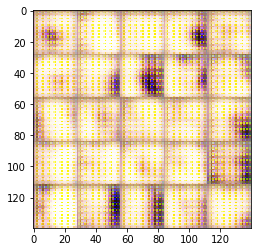

Epoch 1/1 Step 100... Discriminator Loss: 0.4650... Generator Loss: 2.0457
Epoch 1/1 Step 110... Discriminator Loss: 0.5718... Generator Loss: 1.6488
Epoch 1/1 Step 120... Discriminator Loss: 0.2362... Generator Loss: 3.0101
Epoch 1/1 Step 130... Discriminator Loss: 0.0832... Generator Loss: 3.1222
Epoch 1/1 Step 140... Discriminator Loss: 2.1253... Generator Loss: 0.1512
Epoch 1/1 Step 150... Discriminator Loss: 1.0182... Generator Loss: 0.6352
Epoch 1/1 Step 160... Discriminator Loss: 0.1382... Generator Loss: 2.8962
Epoch 1/1 Step 170... Discriminator Loss: 0.0924... Generator Loss: 3.1623
Epoch 1/1 Step 180... Discriminator Loss: 0.0696... Generator Loss: 3.3347
Epoch 1/1 Step 190... Discriminator Loss: 0.0356... Generator Loss: 3.9526


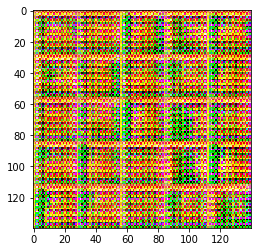

Epoch 1/1 Step 200... Discriminator Loss: 0.0316... Generator Loss: 3.9839
Epoch 1/1 Step 210... Discriminator Loss: 0.0342... Generator Loss: 3.9854
Epoch 1/1 Step 220... Discriminator Loss: 2.6306... Generator Loss: 0.1152
Epoch 1/1 Step 230... Discriminator Loss: 0.3553... Generator Loss: 1.3380
Epoch 1/1 Step 240... Discriminator Loss: 0.0458... Generator Loss: 4.2001
Epoch 1/1 Step 250... Discriminator Loss: 0.0893... Generator Loss: 2.9142
Epoch 1/1 Step 260... Discriminator Loss: 2.0771... Generator Loss: 0.9853
Epoch 1/1 Step 270... Discriminator Loss: 1.5042... Generator Loss: 0.3879
Epoch 1/1 Step 280... Discriminator Loss: 1.0374... Generator Loss: 1.5818
Epoch 1/1 Step 290... Discriminator Loss: 0.7459... Generator Loss: 1.2423


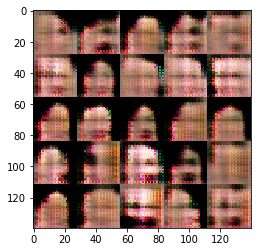

Epoch 1/1 Step 300... Discriminator Loss: 1.3873... Generator Loss: 0.7062
Epoch 1/1 Step 310... Discriminator Loss: 1.4674... Generator Loss: 1.3325
Epoch 1/1 Step 320... Discriminator Loss: 1.0352... Generator Loss: 0.8278
Epoch 1/1 Step 330... Discriminator Loss: 1.1194... Generator Loss: 0.9039
Epoch 1/1 Step 340... Discriminator Loss: 0.7199... Generator Loss: 1.3803
Epoch 1/1 Step 350... Discriminator Loss: 1.1166... Generator Loss: 1.2261
Epoch 1/1 Step 360... Discriminator Loss: 1.5867... Generator Loss: 0.3503
Epoch 1/1 Step 370... Discriminator Loss: 1.0928... Generator Loss: 0.6949
Epoch 1/1 Step 380... Discriminator Loss: 1.0971... Generator Loss: 0.6395
Epoch 1/1 Step 390... Discriminator Loss: 1.4025... Generator Loss: 0.5715


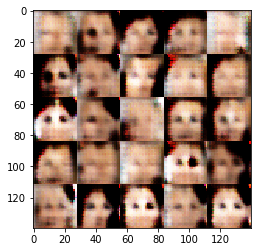

Epoch 1/1 Step 400... Discriminator Loss: 1.2330... Generator Loss: 1.1123
Epoch 1/1 Step 410... Discriminator Loss: 1.7780... Generator Loss: 1.9632
Epoch 1/1 Step 420... Discriminator Loss: 1.1983... Generator Loss: 1.6548
Epoch 1/1 Step 430... Discriminator Loss: 1.2327... Generator Loss: 0.6593
Epoch 1/1 Step 440... Discriminator Loss: 2.0167... Generator Loss: 0.4147
Epoch 1/1 Step 450... Discriminator Loss: 1.0053... Generator Loss: 0.8762
Epoch 1/1 Step 460... Discriminator Loss: 0.6916... Generator Loss: 1.1464
Epoch 1/1 Step 470... Discriminator Loss: 1.2699... Generator Loss: 1.3891
Epoch 1/1 Step 480... Discriminator Loss: 1.2521... Generator Loss: 0.8042
Epoch 1/1 Step 490... Discriminator Loss: 1.2063... Generator Loss: 0.5557


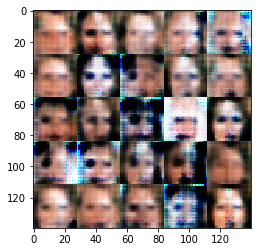

Epoch 1/1 Step 500... Discriminator Loss: 1.1245... Generator Loss: 0.8915
Epoch 1/1 Step 510... Discriminator Loss: 1.3243... Generator Loss: 0.8377
Epoch 1/1 Step 520... Discriminator Loss: 0.4862... Generator Loss: 1.5424
Epoch 1/1 Step 530... Discriminator Loss: 1.5253... Generator Loss: 2.2230
Epoch 1/1 Step 540... Discriminator Loss: 2.3529... Generator Loss: 0.1175
Epoch 1/1 Step 550... Discriminator Loss: 0.5341... Generator Loss: 2.7473
Epoch 1/1 Step 560... Discriminator Loss: 1.4547... Generator Loss: 1.4081
Epoch 1/1 Step 570... Discriminator Loss: 1.1925... Generator Loss: 1.0764
Epoch 1/1 Step 580... Discriminator Loss: 1.2260... Generator Loss: 0.8289
Epoch 1/1 Step 590... Discriminator Loss: 1.5599... Generator Loss: 1.1271


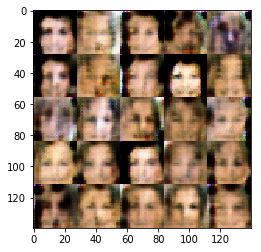

Epoch 1/1 Step 600... Discriminator Loss: 1.3255... Generator Loss: 0.5415
Epoch 1/1 Step 610... Discriminator Loss: 1.9599... Generator Loss: 2.2744
Epoch 1/1 Step 620... Discriminator Loss: 1.3428... Generator Loss: 0.4913
Epoch 1/1 Step 630... Discriminator Loss: 1.4361... Generator Loss: 0.4349
Epoch 1/1 Step 640... Discriminator Loss: 1.3505... Generator Loss: 0.7362
Epoch 1/1 Step 650... Discriminator Loss: 1.2430... Generator Loss: 0.5958
Epoch 1/1 Step 660... Discriminator Loss: 1.1550... Generator Loss: 0.8676
Epoch 1/1 Step 670... Discriminator Loss: 1.1554... Generator Loss: 0.6220
Epoch 1/1 Step 680... Discriminator Loss: 1.2980... Generator Loss: 1.1809
Epoch 1/1 Step 690... Discriminator Loss: 1.4009... Generator Loss: 0.4571


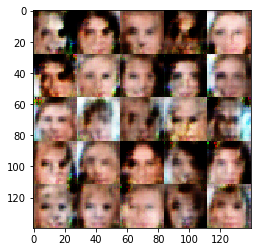

Epoch 1/1 Step 700... Discriminator Loss: 1.2933... Generator Loss: 0.5755
Epoch 1/1 Step 710... Discriminator Loss: 1.3348... Generator Loss: 1.2077
Epoch 1/1 Step 720... Discriminator Loss: 1.1263... Generator Loss: 1.5149
Epoch 1/1 Step 730... Discriminator Loss: 1.5339... Generator Loss: 2.1960
Epoch 1/1 Step 740... Discriminator Loss: 1.1543... Generator Loss: 1.2117
Epoch 1/1 Step 750... Discriminator Loss: 1.1963... Generator Loss: 0.6609
Epoch 1/1 Step 760... Discriminator Loss: 0.9844... Generator Loss: 0.8318
Epoch 1/1 Step 770... Discriminator Loss: 1.5507... Generator Loss: 0.3117
Epoch 1/1 Step 780... Discriminator Loss: 1.7598... Generator Loss: 2.0158
Epoch 1/1 Step 790... Discriminator Loss: 1.1833... Generator Loss: 0.6277


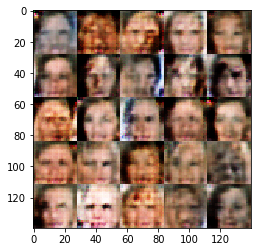

Epoch 1/1 Step 800... Discriminator Loss: 1.7221... Generator Loss: 0.3011
Epoch 1/1 Step 810... Discriminator Loss: 1.1960... Generator Loss: 1.5037
Epoch 1/1 Step 820... Discriminator Loss: 1.4702... Generator Loss: 0.3643
Epoch 1/1 Step 830... Discriminator Loss: 1.2122... Generator Loss: 0.5955
Epoch 1/1 Step 840... Discriminator Loss: 1.0900... Generator Loss: 0.7802
Epoch 1/1 Step 850... Discriminator Loss: 1.2347... Generator Loss: 0.5495
Epoch 1/1 Step 860... Discriminator Loss: 1.1835... Generator Loss: 0.8677
Epoch 1/1 Step 870... Discriminator Loss: 1.4523... Generator Loss: 1.8437
Epoch 1/1 Step 880... Discriminator Loss: 1.1150... Generator Loss: 0.9016
Epoch 1/1 Step 890... Discriminator Loss: 1.1756... Generator Loss: 1.0193


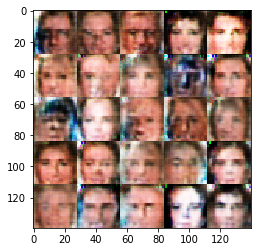

Epoch 1/1 Step 900... Discriminator Loss: 1.1589... Generator Loss: 0.7507
Epoch 1/1 Step 910... Discriminator Loss: 1.0545... Generator Loss: 0.8954
Epoch 1/1 Step 920... Discriminator Loss: 1.2361... Generator Loss: 0.8976
Epoch 1/1 Step 930... Discriminator Loss: 1.0319... Generator Loss: 1.2541
Epoch 1/1 Step 940... Discriminator Loss: 1.2786... Generator Loss: 0.8364
Epoch 1/1 Step 950... Discriminator Loss: 1.0633... Generator Loss: 1.7705
Epoch 1/1 Step 960... Discriminator Loss: 1.6314... Generator Loss: 1.7707
Epoch 1/1 Step 970... Discriminator Loss: 1.0913... Generator Loss: 0.9856
Epoch 1/1 Step 980... Discriminator Loss: 0.9254... Generator Loss: 0.9147
Epoch 1/1 Step 990... Discriminator Loss: 0.9617... Generator Loss: 1.0585


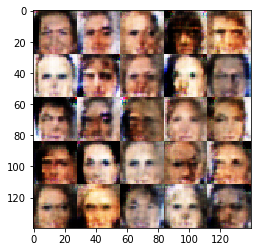

Epoch 1/1 Step 1000... Discriminator Loss: 1.3950... Generator Loss: 1.3442
Epoch 1/1 Step 1010... Discriminator Loss: 1.0789... Generator Loss: 1.3848
Epoch 1/1 Step 1020... Discriminator Loss: 1.2259... Generator Loss: 0.7703
Epoch 1/1 Step 1030... Discriminator Loss: 1.4334... Generator Loss: 0.8524
Epoch 1/1 Step 1040... Discriminator Loss: 0.9995... Generator Loss: 1.7256
Epoch 1/1 Step 1050... Discriminator Loss: 1.1850... Generator Loss: 1.0150
Epoch 1/1 Step 1060... Discriminator Loss: 1.7166... Generator Loss: 0.2471
Epoch 1/1 Step 1070... Discriminator Loss: 1.3243... Generator Loss: 0.4811
Epoch 1/1 Step 1080... Discriminator Loss: 1.1736... Generator Loss: 1.2138
Epoch 1/1 Step 1090... Discriminator Loss: 1.6650... Generator Loss: 0.3160


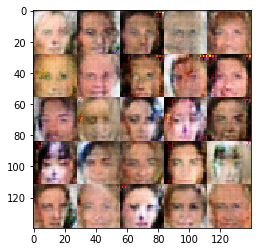

Epoch 1/1 Step 1100... Discriminator Loss: 1.1390... Generator Loss: 0.6617
Epoch 1/1 Step 1110... Discriminator Loss: 1.1066... Generator Loss: 1.3826
Epoch 1/1 Step 1120... Discriminator Loss: 1.1543... Generator Loss: 1.5865
Epoch 1/1 Step 1130... Discriminator Loss: 1.2371... Generator Loss: 0.6238
Epoch 1/1 Step 1140... Discriminator Loss: 1.1807... Generator Loss: 1.0273
Epoch 1/1 Step 1150... Discriminator Loss: 1.4777... Generator Loss: 0.7333
Epoch 1/1 Step 1160... Discriminator Loss: 1.3532... Generator Loss: 0.5069
Epoch 1/1 Step 1170... Discriminator Loss: 1.0699... Generator Loss: 1.5616
Epoch 1/1 Step 1180... Discriminator Loss: 0.9263... Generator Loss: 1.3369
Epoch 1/1 Step 1190... Discriminator Loss: 1.1282... Generator Loss: 1.3538


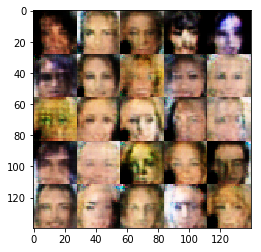

Epoch 1/1 Step 1200... Discriminator Loss: 1.3435... Generator Loss: 0.4442
Epoch 1/1 Step 1210... Discriminator Loss: 0.7406... Generator Loss: 1.3584
Epoch 1/1 Step 1220... Discriminator Loss: 1.6260... Generator Loss: 0.6087
Epoch 1/1 Step 1230... Discriminator Loss: 1.1217... Generator Loss: 0.9623
Epoch 1/1 Step 1240... Discriminator Loss: 1.1128... Generator Loss: 0.6562
Epoch 1/1 Step 1250... Discriminator Loss: 1.3075... Generator Loss: 0.6762
Epoch 1/1 Step 1260... Discriminator Loss: 1.4779... Generator Loss: 0.3634
Epoch 1/1 Step 1270... Discriminator Loss: 1.1896... Generator Loss: 0.8965
Epoch 1/1 Step 1280... Discriminator Loss: 1.1676... Generator Loss: 1.1106
Epoch 1/1 Step 1290... Discriminator Loss: 1.4298... Generator Loss: 0.4124


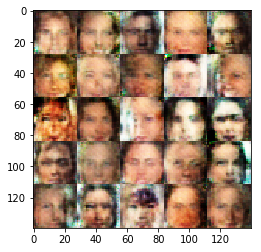

Epoch 1/1 Step 1300... Discriminator Loss: 1.2812... Generator Loss: 0.4599
Epoch 1/1 Step 1310... Discriminator Loss: 1.6617... Generator Loss: 0.2823
Epoch 1/1 Step 1320... Discriminator Loss: 1.8036... Generator Loss: 0.2323
Epoch 1/1 Step 1330... Discriminator Loss: 1.3972... Generator Loss: 1.0419
Epoch 1/1 Step 1340... Discriminator Loss: 1.0057... Generator Loss: 1.2693
Epoch 1/1 Step 1350... Discriminator Loss: 1.4010... Generator Loss: 0.5970
Epoch 1/1 Step 1360... Discriminator Loss: 1.4417... Generator Loss: 0.3759
Epoch 1/1 Step 1370... Discriminator Loss: 1.2844... Generator Loss: 1.5198
Epoch 1/1 Step 1380... Discriminator Loss: 1.3491... Generator Loss: 0.4409
Epoch 1/1 Step 1390... Discriminator Loss: 1.1731... Generator Loss: 0.7134


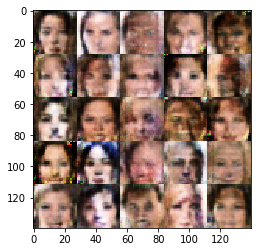

Epoch 1/1 Step 1400... Discriminator Loss: 1.3095... Generator Loss: 0.9234
Epoch 1/1 Step 1410... Discriminator Loss: 1.2992... Generator Loss: 1.6708
Epoch 1/1 Step 1420... Discriminator Loss: 1.3898... Generator Loss: 0.7986
Epoch 1/1 Step 1430... Discriminator Loss: 1.2085... Generator Loss: 0.8997
Epoch 1/1 Step 1440... Discriminator Loss: 1.5739... Generator Loss: 0.3307
Epoch 1/1 Step 1450... Discriminator Loss: 1.4615... Generator Loss: 0.4970
Epoch 1/1 Step 1460... Discriminator Loss: 1.4993... Generator Loss: 0.9944
Epoch 1/1 Step 1470... Discriminator Loss: 1.3728... Generator Loss: 0.5741
Epoch 1/1 Step 1480... Discriminator Loss: 1.1560... Generator Loss: 0.6595
Epoch 1/1 Step 1490... Discriminator Loss: 1.2804... Generator Loss: 0.7480


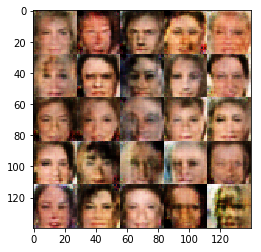

Epoch 1/1 Step 1500... Discriminator Loss: 1.3716... Generator Loss: 0.5984
Epoch 1/1 Step 1510... Discriminator Loss: 1.4772... Generator Loss: 0.3676
Epoch 1/1 Step 1520... Discriminator Loss: 1.0080... Generator Loss: 1.2731
Epoch 1/1 Step 1530... Discriminator Loss: 1.3305... Generator Loss: 0.5918
Epoch 1/1 Step 1540... Discriminator Loss: 1.7540... Generator Loss: 0.2517
Epoch 1/1 Step 1550... Discriminator Loss: 0.8031... Generator Loss: 1.1433
Epoch 1/1 Step 1560... Discriminator Loss: 1.2025... Generator Loss: 1.0843
Epoch 1/1 Step 1570... Discriminator Loss: 1.8653... Generator Loss: 0.2127
Epoch 1/1 Step 1580... Discriminator Loss: 1.2026... Generator Loss: 0.7838
Epoch 1/1 Step 1590... Discriminator Loss: 1.5303... Generator Loss: 0.3958


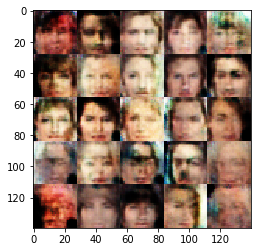

Epoch 1/1 Step 1600... Discriminator Loss: 1.2031... Generator Loss: 0.8374
Epoch 1/1 Step 1610... Discriminator Loss: 0.8072... Generator Loss: 1.3951
Epoch 1/1 Step 1620... Discriminator Loss: 1.2564... Generator Loss: 0.7707
Epoch 1/1 Step 1630... Discriminator Loss: 1.7235... Generator Loss: 1.3712
Epoch 1/1 Step 1640... Discriminator Loss: 1.0786... Generator Loss: 0.9565
Epoch 1/1 Step 1650... Discriminator Loss: 0.8979... Generator Loss: 0.7768
Epoch 1/1 Step 1660... Discriminator Loss: 1.4040... Generator Loss: 0.7215
Epoch 1/1 Step 1670... Discriminator Loss: 1.3735... Generator Loss: 0.5531
Epoch 1/1 Step 1680... Discriminator Loss: 1.2852... Generator Loss: 0.8526
Epoch 1/1 Step 1690... Discriminator Loss: 1.1283... Generator Loss: 0.8238


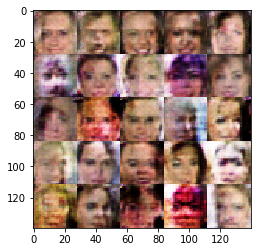

Epoch 1/1 Step 1700... Discriminator Loss: 1.3769... Generator Loss: 0.8748
Epoch 1/1 Step 1710... Discriminator Loss: 1.3709... Generator Loss: 0.6908
Epoch 1/1 Step 1720... Discriminator Loss: 1.5670... Generator Loss: 0.2961
Epoch 1/1 Step 1730... Discriminator Loss: 1.3052... Generator Loss: 1.0434
Epoch 1/1 Step 1740... Discriminator Loss: 1.4985... Generator Loss: 0.7980
Epoch 1/1 Step 1750... Discriminator Loss: 1.1555... Generator Loss: 0.7406
Epoch 1/1 Step 1760... Discriminator Loss: 1.2817... Generator Loss: 0.7197
Epoch 1/1 Step 1770... Discriminator Loss: 1.2561... Generator Loss: 0.6628
Epoch 1/1 Step 1780... Discriminator Loss: 0.8873... Generator Loss: 1.1299
Epoch 1/1 Step 1790... Discriminator Loss: 1.2441... Generator Loss: 0.8908


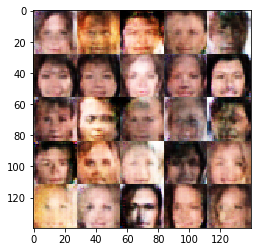

Epoch 1/1 Step 1800... Discriminator Loss: 1.3356... Generator Loss: 0.6513
Epoch 1/1 Step 1810... Discriminator Loss: 1.0443... Generator Loss: 1.0632
Epoch 1/1 Step 1820... Discriminator Loss: 1.4086... Generator Loss: 0.5031
Epoch 1/1 Step 1830... Discriminator Loss: 1.2732... Generator Loss: 0.6183
Epoch 1/1 Step 1840... Discriminator Loss: 1.2154... Generator Loss: 0.5169
Epoch 1/1 Step 1850... Discriminator Loss: 1.3231... Generator Loss: 0.9082
Epoch 1/1 Step 1860... Discriminator Loss: 1.3900... Generator Loss: 0.4851
Epoch 1/1 Step 1870... Discriminator Loss: 1.2681... Generator Loss: 0.6600
Epoch 1/1 Step 1880... Discriminator Loss: 1.5468... Generator Loss: 0.4097
Epoch 1/1 Step 1890... Discriminator Loss: 1.2251... Generator Loss: 0.8085


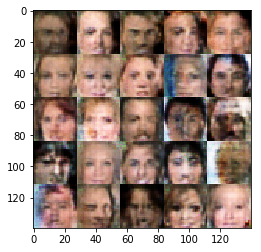

Epoch 1/1 Step 1900... Discriminator Loss: 1.1508... Generator Loss: 0.6067
Epoch 1/1 Step 1910... Discriminator Loss: 1.2473... Generator Loss: 0.7868
Epoch 1/1 Step 1920... Discriminator Loss: 1.3183... Generator Loss: 0.6109
Epoch 1/1 Step 1930... Discriminator Loss: 1.3573... Generator Loss: 0.6978
Epoch 1/1 Step 1940... Discriminator Loss: 1.1351... Generator Loss: 0.7733
Epoch 1/1 Step 1950... Discriminator Loss: 1.2575... Generator Loss: 0.6514
Epoch 1/1 Step 1960... Discriminator Loss: 1.4068... Generator Loss: 0.5445
Epoch 1/1 Step 1970... Discriminator Loss: 1.3981... Generator Loss: 0.6776
Epoch 1/1 Step 1980... Discriminator Loss: 1.3813... Generator Loss: 0.8439
Epoch 1/1 Step 1990... Discriminator Loss: 1.2964... Generator Loss: 0.7566


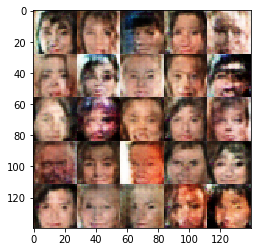

Epoch 1/1 Step 2000... Discriminator Loss: 1.4241... Generator Loss: 0.7249
Epoch 1/1 Step 2010... Discriminator Loss: 1.3765... Generator Loss: 0.6160
Epoch 1/1 Step 2020... Discriminator Loss: 1.2767... Generator Loss: 0.8092
Epoch 1/1 Step 2030... Discriminator Loss: 1.4042... Generator Loss: 0.6662
Epoch 1/1 Step 2040... Discriminator Loss: 1.2946... Generator Loss: 0.6666
Epoch 1/1 Step 2050... Discriminator Loss: 1.3360... Generator Loss: 0.6571
Epoch 1/1 Step 2060... Discriminator Loss: 1.0464... Generator Loss: 0.9746
Epoch 1/1 Step 2070... Discriminator Loss: 1.3036... Generator Loss: 0.6715
Epoch 1/1 Step 2080... Discriminator Loss: 1.3434... Generator Loss: 0.6265
Epoch 1/1 Step 2090... Discriminator Loss: 1.2953... Generator Loss: 0.6413


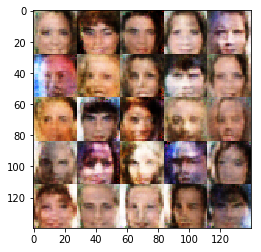

Epoch 1/1 Step 2100... Discriminator Loss: 1.2878... Generator Loss: 0.7580
Epoch 1/1 Step 2110... Discriminator Loss: 1.3926... Generator Loss: 0.6475
Epoch 1/1 Step 2120... Discriminator Loss: 1.3311... Generator Loss: 0.6356
Epoch 1/1 Step 2130... Discriminator Loss: 1.1182... Generator Loss: 0.6753
Epoch 1/1 Step 2140... Discriminator Loss: 1.3008... Generator Loss: 0.5859
Epoch 1/1 Step 2150... Discriminator Loss: 1.1923... Generator Loss: 0.9735
Epoch 1/1 Step 2160... Discriminator Loss: 1.4198... Generator Loss: 0.6458
Epoch 1/1 Step 2170... Discriminator Loss: 1.2611... Generator Loss: 0.5226
Epoch 1/1 Step 2180... Discriminator Loss: 1.2688... Generator Loss: 0.8137
Epoch 1/1 Step 2190... Discriminator Loss: 1.4061... Generator Loss: 0.6073


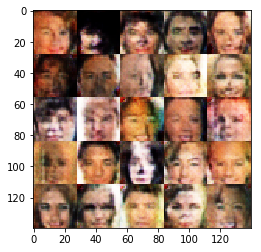

Epoch 1/1 Step 2200... Discriminator Loss: 1.2460... Generator Loss: 0.7620
Epoch 1/1 Step 2210... Discriminator Loss: 1.4944... Generator Loss: 0.4609
Epoch 1/1 Step 2220... Discriminator Loss: 1.4075... Generator Loss: 0.5857
Epoch 1/1 Step 2230... Discriminator Loss: 1.3866... Generator Loss: 0.8268
Epoch 1/1 Step 2240... Discriminator Loss: 1.1877... Generator Loss: 0.9974
Epoch 1/1 Step 2250... Discriminator Loss: 1.2208... Generator Loss: 1.0633
Epoch 1/1 Step 2260... Discriminator Loss: 1.4483... Generator Loss: 0.8466
Epoch 1/1 Step 2270... Discriminator Loss: 1.3801... Generator Loss: 0.6986
Epoch 1/1 Step 2280... Discriminator Loss: 1.3315... Generator Loss: 0.9447
Epoch 1/1 Step 2290... Discriminator Loss: 1.0706... Generator Loss: 0.8002


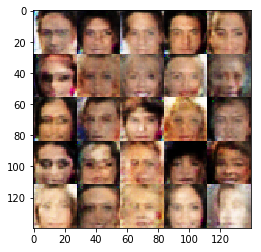

Epoch 1/1 Step 2300... Discriminator Loss: 1.2600... Generator Loss: 0.5839
Epoch 1/1 Step 2310... Discriminator Loss: 1.2795... Generator Loss: 0.5805
Epoch 1/1 Step 2320... Discriminator Loss: 1.3960... Generator Loss: 0.5543
Epoch 1/1 Step 2330... Discriminator Loss: 1.1399... Generator Loss: 0.7402
Epoch 1/1 Step 2340... Discriminator Loss: 1.3118... Generator Loss: 0.9122
Epoch 1/1 Step 2350... Discriminator Loss: 1.2734... Generator Loss: 0.6391
Epoch 1/1 Step 2360... Discriminator Loss: 1.3428... Generator Loss: 0.8122
Epoch 1/1 Step 2370... Discriminator Loss: 1.6323... Generator Loss: 1.2749
Epoch 1/1 Step 2380... Discriminator Loss: 1.3789... Generator Loss: 0.9216
Epoch 1/1 Step 2390... Discriminator Loss: 1.2867... Generator Loss: 0.8024


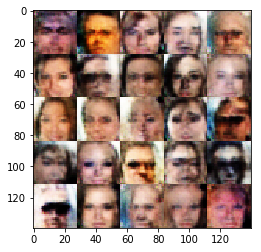

Epoch 1/1 Step 2400... Discriminator Loss: 1.3568... Generator Loss: 1.3815
Epoch 1/1 Step 2410... Discriminator Loss: 1.2925... Generator Loss: 0.7657
Epoch 1/1 Step 2420... Discriminator Loss: 1.3640... Generator Loss: 0.6948
Epoch 1/1 Step 2430... Discriminator Loss: 1.3680... Generator Loss: 0.6869
Epoch 1/1 Step 2440... Discriminator Loss: 1.3850... Generator Loss: 0.6804
Epoch 1/1 Step 2450... Discriminator Loss: 1.1332... Generator Loss: 1.0064
Epoch 1/1 Step 2460... Discriminator Loss: 1.3097... Generator Loss: 0.6208
Epoch 1/1 Step 2470... Discriminator Loss: 1.3876... Generator Loss: 1.1217
Epoch 1/1 Step 2480... Discriminator Loss: 1.3456... Generator Loss: 0.8220
Epoch 1/1 Step 2490... Discriminator Loss: 1.5165... Generator Loss: 1.6481


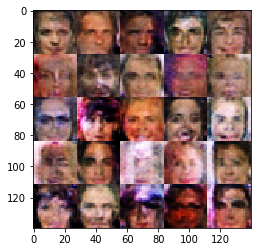

Epoch 1/1 Step 2500... Discriminator Loss: 1.4138... Generator Loss: 0.5910
Epoch 1/1 Step 2510... Discriminator Loss: 1.1535... Generator Loss: 0.9129
Epoch 1/1 Step 2520... Discriminator Loss: 1.3244... Generator Loss: 0.6166
Epoch 1/1 Step 2530... Discriminator Loss: 1.1139... Generator Loss: 0.9354
Epoch 1/1 Step 2540... Discriminator Loss: 1.2174... Generator Loss: 0.7428
Epoch 1/1 Step 2550... Discriminator Loss: 1.3403... Generator Loss: 0.5938
Epoch 1/1 Step 2560... Discriminator Loss: 1.3565... Generator Loss: 0.6420
Epoch 1/1 Step 2570... Discriminator Loss: 1.1955... Generator Loss: 0.7692
Epoch 1/1 Step 2580... Discriminator Loss: 1.4171... Generator Loss: 0.4929
Epoch 1/1 Step 2590... Discriminator Loss: 1.3369... Generator Loss: 0.6580


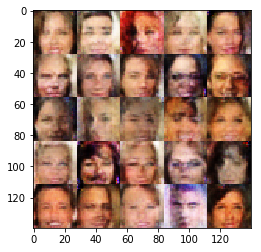

Epoch 1/1 Step 2600... Discriminator Loss: 1.1269... Generator Loss: 0.9617
Epoch 1/1 Step 2610... Discriminator Loss: 1.5989... Generator Loss: 0.4428
Epoch 1/1 Step 2620... Discriminator Loss: 1.3523... Generator Loss: 0.5560
Epoch 1/1 Step 2630... Discriminator Loss: 1.5606... Generator Loss: 0.6051
Epoch 1/1 Step 2640... Discriminator Loss: 1.3951... Generator Loss: 0.7132
Epoch 1/1 Step 2650... Discriminator Loss: 1.3665... Generator Loss: 0.6835
Epoch 1/1 Step 2660... Discriminator Loss: 1.2504... Generator Loss: 0.7888
Epoch 1/1 Step 2670... Discriminator Loss: 1.3070... Generator Loss: 0.7624
Epoch 1/1 Step 2680... Discriminator Loss: 1.3192... Generator Loss: 0.6905
Epoch 1/1 Step 2690... Discriminator Loss: 1.3859... Generator Loss: 0.7351


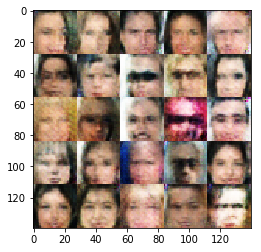

Epoch 1/1 Step 2700... Discriminator Loss: 1.3744... Generator Loss: 0.6937
Epoch 1/1 Step 2710... Discriminator Loss: 1.2386... Generator Loss: 0.7570
Epoch 1/1 Step 2720... Discriminator Loss: 1.4162... Generator Loss: 0.6434
Epoch 1/1 Step 2730... Discriminator Loss: 1.3447... Generator Loss: 0.6997
Epoch 1/1 Step 2740... Discriminator Loss: 1.3134... Generator Loss: 0.7341
Epoch 1/1 Step 2750... Discriminator Loss: 1.3993... Generator Loss: 0.6533
Epoch 1/1 Step 2760... Discriminator Loss: 1.3450... Generator Loss: 0.7317
Epoch 1/1 Step 2770... Discriminator Loss: 1.3933... Generator Loss: 0.6523
Epoch 1/1 Step 2780... Discriminator Loss: 1.3218... Generator Loss: 0.7261
Epoch 1/1 Step 2790... Discriminator Loss: 1.2901... Generator Loss: 0.7874


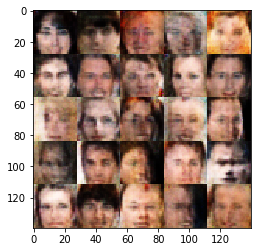

Epoch 1/1 Step 2800... Discriminator Loss: 1.3194... Generator Loss: 0.6632
Epoch 1/1 Step 2810... Discriminator Loss: 1.5252... Generator Loss: 0.5986
Epoch 1/1 Step 2820... Discriminator Loss: 1.3236... Generator Loss: 0.6725
Epoch 1/1 Step 2830... Discriminator Loss: 1.2558... Generator Loss: 0.7658
Epoch 1/1 Step 2840... Discriminator Loss: 1.3822... Generator Loss: 0.6039
Epoch 1/1 Step 2850... Discriminator Loss: 1.2150... Generator Loss: 0.7654
Epoch 1/1 Step 2860... Discriminator Loss: 1.4178... Generator Loss: 0.7292
Epoch 1/1 Step 2870... Discriminator Loss: 1.3736... Generator Loss: 0.6417
Epoch 1/1 Step 2880... Discriminator Loss: 1.2868... Generator Loss: 0.6973
Epoch 1/1 Step 2890... Discriminator Loss: 1.3065... Generator Loss: 0.7518


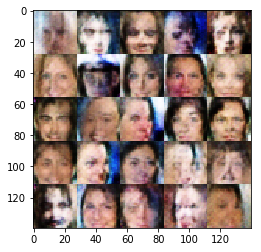

Epoch 1/1 Step 2900... Discriminator Loss: 1.3304... Generator Loss: 0.6507
Epoch 1/1 Step 2910... Discriminator Loss: 1.5155... Generator Loss: 0.5613
Epoch 1/1 Step 2920... Discriminator Loss: 1.2517... Generator Loss: 0.7475
Epoch 1/1 Step 2930... Discriminator Loss: 1.2959... Generator Loss: 0.7199
Epoch 1/1 Step 2940... Discriminator Loss: 1.3718... Generator Loss: 0.6382
Epoch 1/1 Step 2950... Discriminator Loss: 1.3224... Generator Loss: 0.7335
Epoch 1/1 Step 2960... Discriminator Loss: 1.2003... Generator Loss: 0.7067
Epoch 1/1 Step 2970... Discriminator Loss: 1.5993... Generator Loss: 0.9646
Epoch 1/1 Step 2980... Discriminator Loss: 1.3085... Generator Loss: 0.5344
Epoch 1/1 Step 2990... Discriminator Loss: 1.3596... Generator Loss: 0.6439


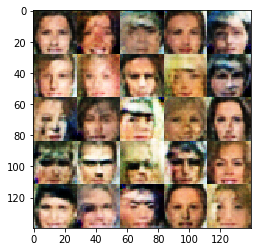

Epoch 1/1 Step 3000... Discriminator Loss: 1.3499... Generator Loss: 0.5747
Epoch 1/1 Step 3010... Discriminator Loss: 1.2808... Generator Loss: 0.8615
Epoch 1/1 Step 3020... Discriminator Loss: 1.2967... Generator Loss: 0.7231
Epoch 1/1 Step 3030... Discriminator Loss: 1.2698... Generator Loss: 0.8117
Epoch 1/1 Step 3040... Discriminator Loss: 1.4329... Generator Loss: 0.6576
Epoch 1/1 Step 3050... Discriminator Loss: 1.3755... Generator Loss: 0.6264
Epoch 1/1 Step 3060... Discriminator Loss: 1.2310... Generator Loss: 0.6429
Epoch 1/1 Step 3070... Discriminator Loss: 1.4439... Generator Loss: 0.5961
Epoch 1/1 Step 3080... Discriminator Loss: 1.3305... Generator Loss: 0.7007
Epoch 1/1 Step 3090... Discriminator Loss: 1.4520... Generator Loss: 0.6985


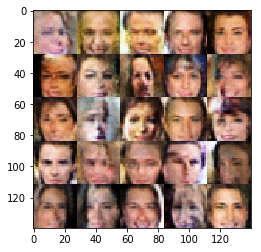

Epoch 1/1 Step 3100... Discriminator Loss: 1.2055... Generator Loss: 0.6400
Epoch 1/1 Step 3110... Discriminator Loss: 1.4254... Generator Loss: 0.5184
Epoch 1/1 Step 3120... Discriminator Loss: 1.3583... Generator Loss: 0.6529
Epoch 1/1 Step 3130... Discriminator Loss: 1.2806... Generator Loss: 0.7468
Epoch 1/1 Step 3140... Discriminator Loss: 1.2250... Generator Loss: 0.8402
Epoch 1/1 Step 3150... Discriminator Loss: 1.3281... Generator Loss: 0.6955
Epoch 1/1 Step 3160... Discriminator Loss: 1.5049... Generator Loss: 0.5274


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.